# Outline
1. preprocesing
    1. standardization
    1. one-hot encoding
1. Modeling
    1. LinerModel
        - Ridge
        - Lasso
    1. SVR
    1. Tree model
        - GBDT (LightGBM)
        - RandomForest 
1. Tuning of each model hyperparameter
1. Stacking
1. Ensemble

# 0.Module

In [211]:
import os
import re
import datetime
from copy import deepcopy
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SequentialFeatureSelector
from sklearn.base import BaseEstimator, RegressorMixin
import lightgbm as lgb
# from lightgbm import log
from EDA import EDA
pd.options.display.precision = 2
np.set_printoptions(precision=4)

def RMSE(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

def train_and_valied(model: BaseEstimator, X_train: pd.DataFrame=None, y_train: pd.Series=None,
                         X_test: pd.DataFrame=None, y_test: pd.Series=None, scoring: str="RMSE", aditional_kwargs: dict={}) -> BaseEstimator:
    model.fit(X=X_train, y=y_train, **aditional_kwargs)
    y_pred = model.predict(X=X_test)
    # print(f"y_pred={y_pred}")
    if scoring=="RMSE":
        score = RMSE(y_true=y_test, y_pred=y_pred)
    
    print(f"{scoring} : {score:.4f}")

    return model

# 1.preprocessing

In [251]:
train_data_raw = EDA(pd.read_csv("./data/train.csv", index_col=0, decimal=","))
train_data = EDA(pd.read_csv("./data/train_after_EDA.csv", index_col=0, decimal=","))
test_data = EDA(pd.read_csv("./data/test_after_EDA.csv", index_col=0, decimal=","))

# なぜか文字列として読み込まれてしまう特徴量を型変換
after = set(train_data.categorical_feature.columns)
before = set(train_data_raw.categorical_feature.columns)
diff_feature = after-before
for name in diff_feature:
    if name == "SalePrice":
        train_data.data[name] = train_data.data[name].astype(float)
    else:
        train_data.data[name] = train_data.data[name].astype(float)
        test_data.data[name] = test_data.data[name].astype(float)


X = deepcopy(train_data.data.drop('SalePrice', axis=1))
X['datatype'] = "train"
temp = deepcopy(test_data.data)
temp['datatype'] = "test"
X_all = pd.concat([X, temp])
y = train_data.data['SalePrice']
train_data.data = X.drop('datatype', axis=1)
train_data.set_categorical_and_numerical_feature()
test_data.set_categorical_and_numerical_feature()
train_data_raw.set_categorical_and_numerical_feature()

display(train_data.data, test_data.data, X_all)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,QualSF,TotalBath,meanRmsSF
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,4.19,9.04,NaN,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,NaN,2,2008,WD,Normal,9.80,3.5,5.37
2,20,RL,4.39,9.17,NaN,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,NaN,5,2007,WD,Normal,9.63,2.5,5.35
3,60,RL,4.23,9.33,NaN,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,NaN,9,2008,WD,Normal,9.85,3.5,5.70
4,70,RL,4.11,9.16,NaN,IR1,Lvl,Corner,Gtl,Crawfor,...,272,0,NaN,2,2006,WD,Abnorml,9.76,2.0,5.51
5,60,RL,4.44,9.57,NaN,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,NaN,12,2008,WD,Normal,10.19,3.5,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,4.14,8.98,NaN,Reg,Lvl,Inside,Gtl,Gilbert,...,0,0,NaN,8,2007,WD,Normal,9.66,2.5,5.47
1457,20,RL,4.45,9.49,NaN,Reg,Lvl,Inside,Gtl,NWAmes,...,0,0,MnPrv,2,2010,WD,Normal,9.98,3.0,5.69
1458,70,RL,4.20,9.11,NaN,Reg,Lvl,Inside,Gtl,Crawfor,...,0,0,GdPrv,5,2010,WD,Normal,10.10,2.0,5.56


,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,QualSF,TotalBath,meanRmsSF
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,4.39,9.36,NaN,Reg,Lvl,Inside,Gtl,NAmes,...,0,120,MnPrv,6,2010,WD,Normal,9.09,1.0,5.19
1462,20,RL,4.41,9.57,NaN,IR1,Lvl,Corner,Gtl,NAmes,...,0,0,NaN,6,2010,WD,Normal,9.68,1.5,5.40
1463,60,RL,4.32,9.53,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,MnPrv,3,2010,WD,Normal,9.46,2.5,5.61
1464,60,RL,4.37,9.21,NaN,IR1,Lvl,Inside,Gtl,Gilbert,...,0,0,NaN,6,2010,WD,Normal,9.63,2.5,5.44
1465,120,RL,3.78,8.52,NaN,IR1,HLS,Inside,Gtl,StoneBr,...,0,144,NaN,1,2010,WD,Normal,9.93,2.0,5.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,3.09,7.57,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,0,0,NaN,6,2006,WD,Normal,8.79,1.5,5.39
2916,160,RM,3.09,7.55,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,0,0,NaN,4,2006,WD,Abnorml,8.79,1.5,5.21
2917,20,RL,5.08,9.90,NaN,Reg,Lvl,Inside,Gtl,Mitchel,...,0,0,NaN,9,2006,WD,Abnorml,9.41,2.0,5.17


,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,QualSF,TotalBath,meanRmsSF,datatype
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,4.19,9.04,NaN,Reg,Lvl,Inside,Gtl,CollgCr,...,0,NaN,2,2008,WD,Normal,9.80,3.5,5.37,train
2,20,RL,4.39,9.17,NaN,Reg,Lvl,FR2,Gtl,Veenker,...,0,NaN,5,2007,WD,Normal,9.63,2.5,5.35,train
3,60,RL,4.23,9.33,NaN,IR1,Lvl,Inside,Gtl,CollgCr,...,0,NaN,9,2008,WD,Normal,9.85,3.5,5.70,train
4,70,RL,4.11,9.16,NaN,IR1,Lvl,Corner,Gtl,Crawfor,...,0,NaN,2,2006,WD,Abnorml,9.76,2.0,5.51,train
5,60,RL,4.44,9.57,NaN,IR1,Lvl,FR2,Gtl,NoRidge,...,0,NaN,12,2008,WD,Normal,10.19,3.5,5.50,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,3.09,7.57,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,0,NaN,6,2006,WD,Normal,8.79,1.5,5.39,test
2916,160,RM,3.09,7.55,NaN,Reg,Lvl,Inside,Gtl,MeadowV,...,0,NaN,4,2006,WD,Abnorml,8.79,1.5,5.21,test
2917,20,RL,5.08,9.90,NaN,Reg,Lvl,Inside,Gtl,Mitchel,...,0,NaN,9,2006,WD,Abnorml,9.41,2.0,5.17,test


## 1.1One-Hot encoding

In [252]:
categorical = train_data.categorical_feature.columns
X_all = pd.get_dummies(data=X_all, columns=categorical, drop_first=True)
train = X_all.loc[X_all["datatype"]=="train", :].drop("datatype", axis=1)
test = X_all.loc[X_all["datatype"]=="test", :].drop("datatype", axis=1)
display(X_all, train, test)

,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,5,2003,196.0,3,3,706,0,...,0,0,0,0,1,0,0,0,1,0
2,20,4.39,9.17,8,1976,0.0,3,3,978,0,...,0,0,0,0,1,0,0,0,1,0
3,60,4.23,9.33,5,2002,162.0,3,3,486,0,...,0,0,0,0,1,0,0,0,1,0
4,70,4.11,9.16,5,1970,0.0,3,4,216,0,...,0,0,0,0,1,0,0,0,0,0
5,60,4.44,9.57,5,2000,350.0,3,3,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,7,1970,0.0,3,3,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2916,160,3.09,7.55,5,1970,0.0,3,3,252.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2917,20,5.08,9.90,7,1996,0.0,3,3,1224.0,0.0,...,0,0,0,0,1,0,0,0,0,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,4.19,9.04,5,2003,196.0,3,3,706,0,...,0,0,0,0,1,0,0,0,1,0
2,20,4.39,9.17,8,1976,0.0,3,3,978,0,...,0,0,0,0,1,0,0,0,1,0
3,60,4.23,9.33,5,2002,162.0,3,3,486,0,...,0,0,0,0,1,0,0,0,1,0
4,70,4.11,9.16,5,1970,0.0,3,4,216,0,...,0,0,0,0,1,0,0,0,0,0
5,60,4.44,9.57,5,2000,350.0,3,3,655,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,4.14,8.98,5,2000,0.0,3,3,0,0,...,0,0,0,0,1,0,0,0,1,0
1457,20,4.45,9.49,6,1988,119.0,3,3,790,163,...,0,0,0,0,1,0,0,0,1,0
1458,70,4.20,9.11,9,2006,0.0,4,4,275,0,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,4.39,9.36,6,1961,0.0,3,3,468.0,144.0,...,0,0,0,0,1,0,0,0,1,0
1462,20,4.41,9.57,6,1958,108.0,3,3,923.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1463,60,4.32,9.53,5,1998,0.0,3,3,791.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1464,60,4.37,9.21,6,1998,20.0,3,3,602.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1465,120,3.78,8.52,5,1992,0.0,3,3,263.0,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,3.09,7.57,7,1970,0.0,3,3,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2916,160,3.09,7.55,5,1970,0.0,3,3,252.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2917,20,5.08,9.90,7,1996,0.0,3,3,1224.0,0.0,...,0,0,0,0,1,0,0,0,0,0


## 1.2.standardization

In [248]:
X_train, X_valied, y_train, y_valied = train_test_split(train, y, test_size=0.2, random_state=42)
X_test = test
print(f"X_train.shape->{X_train.shape}, X_valied.shape->{X_valied.shape}, y_train.shape->{y_train.shape}, y_valied.shape->{y_valied.shape}")

scaler = StandardScaler()
numerical = train_data.numerical_feature.columns
print(numerical)
X_train.loc[:, numerical] = scaler.fit_transform(X=X_train.loc[:, numerical])
X_valied.loc[:, numerical] = scaler.transform(X_valied.loc[:, numerical])
X_test.loc[:, numerical] = scaler.transform(X=X_test.loc[:, numerical])
display(X_train, X_valied, X_test)

X_train.shape->(1164, 180), X_valied.shape->(291, 180), y_train.shape->(1164,), y_valied.shape->(291,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearRemodAdd',
       'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'HeatingQC', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'FireplaceQu', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'QualSF', 'TotalBath', 'meanRmsSF'],
      dtype='object')


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
723,-0.87,0.16,-0.23,1.27,-0.74,-0.6,2.63,-0.04,-0.60,-0.29,...,0,0,0,0,1,0,0,0,1,0
255,-0.87,0.16,-0.17,0.37,-1.37,-0.6,2.63,-0.04,1.09,-0.29,...,0,0,0,0,1,0,0,0,1,0
1067,0.07,-0.38,-0.30,1.27,0.42,-0.6,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
639,-0.63,0.02,-0.08,1.27,-1.72,-0.6,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
1294,0.07,0.50,0.20,-0.53,-0.45,-0.6,-0.23,-0.04,-0.59,-0.29,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,-0.17,-0.90,-0.82,0.37,-1.72,-0.6,-0.23,-0.04,0.51,-0.29,...,0,0,0,0,1,0,0,0,1,0
1135,0.07,-0.49,-0.08,-0.53,0.57,-0.6,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
1300,-0.87,0.38,-0.39,1.27,0.42,-0.6,-0.23,-0.04,-0.25,5.36,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
498,-0.17,-0.33,-6.15e-03,0.37,-1.72,-0.60,2.63,-0.04,-2.78e-01,-0.29,...,0,0,0,0,1,0,0,0,1,0
1266,2.41,-2.01,-1.75e+00,-0.53,0.67,0.67,-0.23,-0.04,1.18e-03,-0.29,...,0,0,0,0,1,0,0,0,1,0
412,3.12,1.28,2.60e+00,-0.53,-1.47,-0.60,-0.23,-0.04,1.40e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0
1050,-0.87,-0.33,3.77e-01,1.27,1.01,-0.60,-0.23,-0.04,-1.04e+00,-0.29,...,0,0,0,0,1,0,0,0,0,0
1037,-0.87,0.92,6.70e-01,-0.53,1.10,-0.19,-0.23,-0.04,1.32e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.07,0.16,4.64e-01,-0.53,-0.79,0.52,-0.23,-0.04,4.62e-01,-0.29,...,0,0,0,0,1,0,0,1,0,0
478,0.07,1.44,7.87e-01,-0.53,1.01,3.89,-0.23,-0.04,-1.04e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0
677,0.30,-0.33,9.39e-02,-3.23,-1.72,-0.60,-0.23,-3.68,-1.04e+00,-0.29,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,-0.87,0.58,0.47,0.37,-1.18,-0.60,-0.23,-0.04,0.04,0.60,...,0,0,0,0,1,0,0,0,1,0
1462,-0.87,0.62,0.87,0.37,-1.33,0.03,-0.23,-0.04,1.09,-0.29,...,0,0,0,0,1,0,0,0,1,0
1463,0.07,0.33,0.81,-0.53,0.62,-0.60,-0.23,-0.04,0.79,-0.29,...,0,0,0,0,1,0,0,0,1,0
1464,0.07,0.50,0.17,0.37,0.62,-0.48,-0.23,-0.04,0.35,-0.29,...,0,0,0,0,1,0,0,0,1,0
1465,1.48,-1.37,-1.18,-0.53,0.33,-0.60,-0.23,-0.04,-0.43,-0.29,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2.41,-3.59,-3.03,1.27,-0.74,-0.60,-0.23,-0.04,-1.04,-0.29,...,0,0,0,0,1,0,0,0,1,0
2916,2.41,-3.59,-3.07,-0.53,-0.74,-0.60,-0.23,-0.04,-0.46,-0.29,...,0,0,0,0,1,0,0,0,0,0
2917,-0.87,2.78,1.53,1.27,0.52,-0.60,-0.23,-0.04,1.78,-0.29,...,0,0,0,0,1,0,0,0,0,0


## 1.2.MinMaxscaling

In [253]:
X_train, X_valied, y_train, y_valied = train_test_split(train, y, test_size=0.2, random_state=42)
X_test = test
print(f"X_train.shape->{X_train.shape}, X_valied.shape->{X_valied.shape}, y_train.shape->{y_train.shape}, y_valied.shape->{y_valied.shape}")

scaler = MinMaxScaler()
numerical = train_data.numerical_feature.columns
print(numerical)
X_train.loc[:, numerical] = scaler.fit_transform(X=X_train.loc[:, numerical])
X_valied.loc[:, numerical] = scaler.transform(X_valied.loc[:, numerical])
X_test.loc[:, numerical] = scaler.transform(X=X_test.loc[:, numerical])
display(X_train, X_valied, X_test)

X_train.shape->(1164, 180), X_valied.shape->(291, 180), y_train.shape->(1164,), y_valied.shape->(291,)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearRemodAdd',
       'MasVnrArea', 'ExterCond', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'HeatingQC', '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath',
       'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'FireplaceQu', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MoSold',
       'YrSold', 'QualSF', 'TotalBath', 'meanRmsSF'],
      dtype='object')


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
723,0.00,0.44,0.34,0.75,0.33,0.0,0.75,0.67,0.09,0.0,...,0,0,0,0,1,0,0,0,1,0
255,0.00,0.44,0.35,0.62,0.12,0.0,0.75,0.67,0.42,0.0,...,0,0,0,0,1,0,0,0,1,0
1067,0.24,0.38,0.33,0.75,0.73,0.0,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
639,0.06,0.42,0.36,0.75,0.00,0.0,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
1294,0.24,0.48,0.39,0.50,0.43,0.0,0.50,0.67,0.09,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.18,0.32,0.28,0.62,0.00,0.0,0.50,0.67,0.31,0.0,...,0,0,0,0,1,0,0,0,1,0
1135,0.24,0.36,0.36,0.50,0.78,0.0,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
1300,0.00,0.47,0.32,0.75,0.73,0.0,0.50,0.67,0.16,0.8,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
498,0.18,0.38,0.36,0.62,0.00,0.00,0.75,0.67,0.15,0.0,...,0,0,0,0,1,0,0,0,1,0
1266,0.82,0.19,0.18,0.50,0.82,0.16,0.50,0.67,0.21,0.0,...,0,0,0,0,1,0,0,0,1,0
412,1.00,0.57,0.63,0.50,0.08,0.00,0.50,0.67,0.48,0.0,...,0,0,0,0,1,0,0,0,1,0
1050,0.00,0.38,0.40,0.75,0.93,0.00,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,0,0
1037,0.00,0.53,0.43,0.50,0.97,0.05,0.50,0.67,0.47,0.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,0.24,0.44,0.41,0.50,0.32,0.14,0.50,0.67,0.30,0.0,...,0,0,0,0,1,0,0,1,0,0
478,0.24,0.59,0.45,0.50,0.93,0.56,0.50,0.67,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0
677,0.29,0.38,0.37,0.12,0.00,0.00,0.50,0.33,0.00,0.0,...,0,0,0,0,1,0,0,0,1,0


,MSSubClass,LotFrontage,LotArea,OverallCond,YearRemodAdd,MasVnrArea,ExterCond,BsmtCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.00,0.49,0.41,0.62,0.18,0.00,0.5,0.67,0.21,0.13,...,0,0,0,0,1,0,0,0,1,0
1462,0.00,0.49,0.45,0.62,0.13,0.08,0.5,0.67,0.42,0.00,...,0,0,0,0,1,0,0,0,1,0
1463,0.24,0.46,0.45,0.50,0.80,0.00,0.5,0.67,0.36,0.00,...,0,0,0,0,1,0,0,0,1,0
1464,0.24,0.48,0.38,0.62,0.80,0.01,0.5,0.67,0.28,0.00,...,0,0,0,0,1,0,0,0,1,0
1465,0.59,0.26,0.24,0.50,0.70,0.00,0.5,0.67,0.12,0.00,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,0.82,0.00,0.05,0.75,0.33,0.00,0.5,0.67,0.00,0.00,...,0,0,0,0,1,0,0,0,1,0
2916,0.82,0.00,0.05,0.50,0.33,0.00,0.5,0.67,0.12,0.00,...,0,0,0,0,1,0,0,0,0,0
2917,0.00,0.75,0.52,0.75,0.77,0.00,0.5,0.67,0.56,0.00,...,0,0,0,0,1,0,0,0,0,0


# 2.Modeling

## 2.1.Linear Model

### 2.1.1.Lasso

In [254]:
model_lasso = LassoCV(eps=0.01, n_alphas=100, max_iter=2000, cv=5, random_state=42, selection="random")
model_lasso = train_and_valied(model=model_lasso, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)

RMSE : 0.1294


In [255]:
coef_lasso = pd.DataFrame(data=model_lasso.coef_.reshape(-1, 1), index=X_train.columns, columns=["coef"])
coef_lasso.loc[:, "coef_abs"] = coef_lasso.loc[:, "coef"].apply(np.abs)
coef_lasso = coef_lasso.sort_values(by="coef_abs", ascending=False)
print(f"model_lasso.alpha_ -> {model_lasso.alpha_:.3f}")
display(coef_lasso.head(20))
print(f"coef is 0 -> ")
print(coef_lasso.loc[coef_lasso["coef"]==0, :].index)
print(f"coef shape -> {coef_lasso.shape}")

model_lasso.alpha_ -> 0.001


,coef,coef_abs
QualSF,1.36,1.36
GarageCars,0.27,0.27
LotArea,0.23,0.23
OverallCond,0.19,0.19
2ndFlrSF,0.17,0.17
BsmtFinSF1,0.15,0.15
Fireplaces,0.12,0.12
SaleType_New,0.11,0.11
TotalBath,0.11,0.11
YearRemodAdd,0.09,0.09


coef is 0 -> 
Index(['MasVnrType_BrkFace', 'Exterior2nd_CmentBd', 'Exterior2nd_CBlock',
       'BsmtFinType1_BLQ', 'Exterior2nd_Stucco', 'Exterior2nd_HdBoard',
       'Exterior2nd_Stone', 'BsmtFinType1_LwQ', 'BsmtExposure_Mn',
       'Exterior2nd_VinylSd',
       ...
       'BldgType_2fmCon', 'Condition1_RRNn', 'Condition1_RRNe',
       'Condition1_RRAn', 'Condition1_RRAe', 'Condition1_PosN',
       'Condition1_PosA', 'Condition1_Feedr', 'Neighborhood_Veenker',
       'SaleCondition_Partial'],
      dtype='object', length=126)
coef shape -> (180, 2)


### 2.1.2Ridge

In [256]:
alphas = [0.1, 1., 10., 100., 500., 1000.]
model_ridge = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error", cv=5)
model_ridge = train_and_valied(model=model_ridge, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)

RMSE : 0.1191


In [257]:
coef_ridge = pd.DataFrame(data=model_ridge.coef_.reshape(-1, 1), index=X_train.columns, columns=["coef"])
coef_ridge.loc[:, "coef_abs"] = coef_ridge.loc[:, "coef"].apply(np.abs)
coef_ridge = coef_ridge.sort_values(by="coef_abs", ascending=False)
print(f"model_ridge.alpha_ -> {model_ridge.alpha_}")
display(coef_ridge.head(10))
# print(f"coef is 0 -> ")
# print(coef.loc[coef["coef"]==0, :].index)
# print(f"coef shape -> {coef.shape}")

model_ridge.alpha_ -> 1.0


,coef,coef_abs
QualSF,0.83,0.83
LotArea,0.34,0.34
BsmtFinSF1,0.33,0.33
2ndFlrSF,0.30,0.30
OverallCond,0.25,0.25
GarageCars,0.25,0.25
BsmtUnfSF,0.19,0.19
TotalBath,0.18,0.18
Functional_Maj2,-0.16,0.16
Foundation_Slab,0.16,0.16


## 2.2.SVR

In [258]:
#C, epsilon
param_grid = {
    "C": [0.1, 1, 10],
    "epsilon": [0.005, 0.01]
}
model_svr = GridSearchCV(SVR(), param_grid=param_grid, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
model_svr = train_and_valied(model=model_svr, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied)
print(f"best params -> {model_svr.best_params_}")

RMSE : 0.1264
best params -> {'C': 1, 'epsilon': 0.005}


## 2.3.Tree Model

### 2.3.1.GBDT (LightGBM)

#### 2.3.1.1.スケール変換されたデータを使った場合

In [216]:
eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

cv_params = {'reg_alpha': [0.0001, 0.003, 0.1],
             'reg_lambda': [0.0001, 0.1],
             'num_leaves': [2, 3, 4, 6],
             'colsample_bytree': [0.4, 0.7, 1.0],
             'subsample': [0.4, 1.0],
             'subsample_freq': [0, 7],
             'min_child_samples': [0, 2, 5, 10]
             }

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              }

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01)

gridcv = GridSearchCV(estimator=model_lgb, param_grid=cv_params, n_jobs=-1, scoring="neg_mean_squared_error", cv=5)
model_lgb = train_and_valied(model=gridcv, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
                      
                      
# model_lgb.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, eval_names=eval_name ,callbacks=callbacks)


RMSE : 0.1310


In [219]:
print(f"best params -> {model_lgb.best_params_}")

best params -> {'colsample_bytree': 0.4, 'min_child_samples': 2, 'num_leaves': 6, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.4, 'subsample_freq': 7}


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

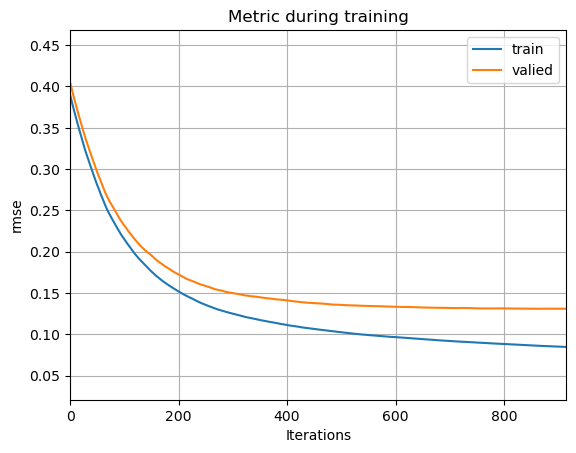

In [221]:
model_lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01, **(model_lgb.best_params_))
model_lgb_best.fit(X_train, y_train, **fit_params)
lgb.plot_metric(model_lgb_best)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

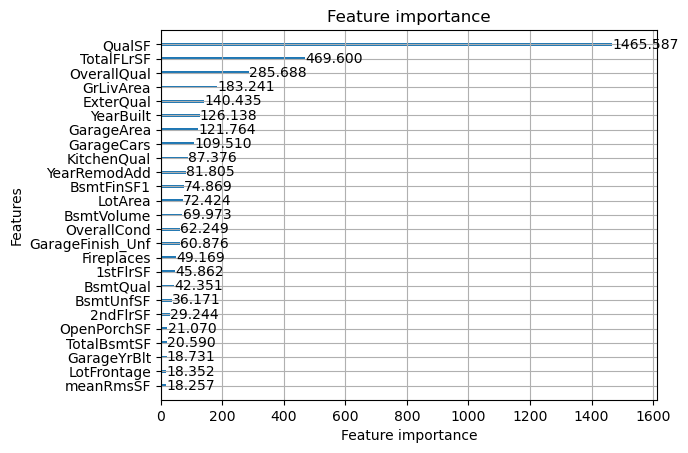

In [222]:
lgb.plot_importance(model_lgb_best, max_num_features=25)

#### 2.3.1.2.スケール変換なし

SalePrice LotArea meanRmsSF TotalBath LotFrontage QualSF MasVnrArea 

c:\Users\miyar\anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\miyar\anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


RMSE : 0.1280


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

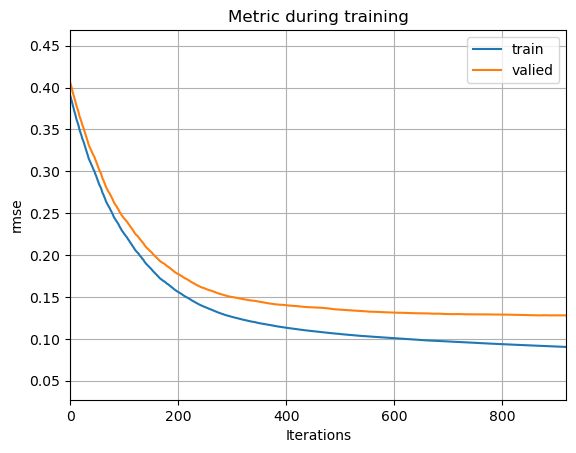

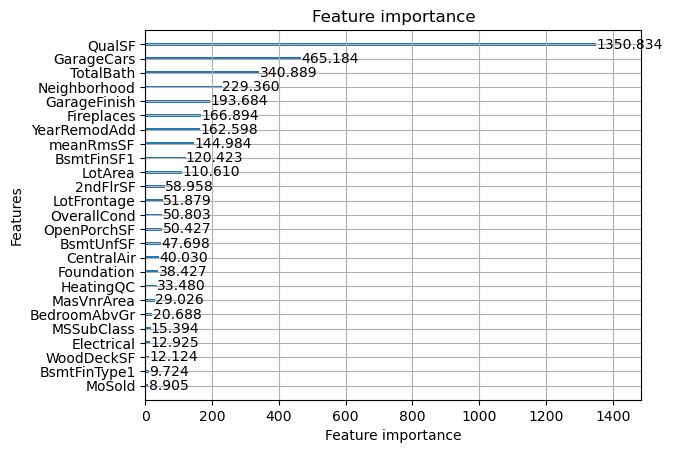

In [244]:
train_data_raw = EDA(pd.read_csv("./data/train.csv", index_col=0, decimal=","))
train_data = EDA(pd.read_csv("./data/train_after_EDA.csv", index_col=0, decimal=","))
test_data = EDA(pd.read_csv("./data/test_after_EDA.csv", index_col=0, decimal=","))

# なぜか文字列として読み込まれてしまう特徴量を型変換
after = set(train_data.categorical_feature.columns)
before = set(train_data_raw.categorical_feature.columns)
diff_feature = after-before
for name in diff_feature:
    print(name, end="  \b")
    if name == "SalePrice":
        train_data.data[name] = train_data.data[name].astype(float)
    else:
        train_data.data[name] = train_data.data[name].astype(float)
        test_data.data[name] = test_data.data[name].astype(float)
        
train_data.set_categorical_and_numerical_feature()
test_data.set_categorical_and_numerical_feature()
categorical_featre = train_data.categorical_feature.columns
train_data.data.loc[:, categorical_featre] = train_data.data.loc[:, categorical_featre].astype('category')
test_data.data.loc[:, categorical_featre] = test_data.data.loc[:, categorical_featre].astype('category')

X = deepcopy(train_data.data.drop('SalePrice', axis=1))
y = train_data.data['SalePrice']

X_train, X_valied, y_train, y_valied = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.data

# temp = EDA(X_train)
# categorical_featre = temp.set_categorical_and_numerical_feature()

model_pram = {'colsample_bytree': 0.4, 'min_child_samples': 2, 'num_leaves': 6, 'reg_alpha': 0.0001, 'reg_lambda': 0.0001, 'subsample': 0.4, 'subsample_freq': 7}

eval_set = [(X_valied, y_valied), (X_train, y_train)]
eval_name = ['valied', 'train']
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=50, verbose=False))

fit_params = {"eval_metric":"rmse", 
              "eval_set":eval_set, 
              "eval_names":eval_name,
              "callbacks":callbacks,
              #"categorical_feature": categorical_featre,
              }

model_lgb_best = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='rmse',
                      random_state=42, n_estimators=10000, importance_type='gain', learning_rate=0.01, **model_pram)

model_lgb_best = train_and_valied(model=model_lgb_best, X_train=X_train, y_train=y_train, X_test=X_valied, y_test=y_valied, aditional_kwargs=fit_params)
lgb.plot_metric(model_lgb_best)
lgb.plot_importance(model_lgb_best, max_num_features=25)

### 2.3.2.RandomForest

# 3.Tuning of each model hyperparameter

# 4.Stacking

# 5.Ensemble